In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import time
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
import os
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
seed = 10
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Prepare dataset
I have used the benchmark VanGogh2Photo dataset for this task.
I have downloaded the dataset by git cloning the repo https://github.com/chickenfingerwu/CycleGAN-vangogh2photo-dataset in my pc and then uploaded the dataset folder.

A domain is the Van Gogh Paintings and B domain is the camera photos

In [4]:
data_dir = '/content/drive/MyDrive/styleTransfer/vangogh2photo_dataset'
train_A_len = len(os.listdir(os.path.join(data_dir, 'trainA')))
train_B_len = len(os.listdir(os.path.join(data_dir, 'trainB')))
print(f'{train_A_len} Van Gogh Paintings, {train_B_len} camera photos')


400 Van Gogh Paintings, 6287 camera photos


## Create Dataset Class

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, tfms, mode = 'Train'):
        super(ImageDataset, self).__init__()
        dir_trainA = os.path.join(data_dir, 'trainA')
        dir_trainB = os.path.join(data_dir, 'trainB')
        dir_testA = os.path.join(data_dir, 'testA')
        dir_testB = os.path.join(data_dir, 'testB')
        if mode == 'Train':
            self.files_a = [os.path.join(dir_trainA, name) for name in sorted(os.listdir(dir_trainA))]
            self.files_b = [os.path.join(dir_trainB, name) for name in sorted(os.listdir(dir_trainB))]
        elif mode == 'Test':
            self.files_a = [os.path.join(dir_testA, name) for name in sorted(os.listdir(dir_testA))]
            self.files_b = [os.path.join(dir_testB, name) for name in sorted(os.listdir(dir_testB))]
        else:
            raise NotImplementedError
        self.tfms = tfms
        self.mode = mode
    def __len__(self):
        return len(self.files_a)
    def __getitem__(self, index):
        random_index = np.random.randint(0, len(self.files_b))
        file_a = Image.open(self.files_a[index])
        file_b = Image.open(self.files_b[index])
        if self.mode == 'Test':
            file_a = file_a.resize((256, 256))
            file_b = file_b.resize((256, 256))

        if self.tfms is not None:
            file_a = self.tfms(file_a)
            file_b = self.tfms(file_b)
        return file_a, file_b



## Create train loader
I have resized all the samples to (256x256)

In [ ]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tfms = tt.Compose([tt.Resize(256),
                tt.RandomHorizontalFlip(0.5),
                tt.RandomVerticalFlip(0.5),
                tt.ToTensor(),
                tt.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
                tt.Normalize(*stats)])

ds = ImageDataset(data_dir, tfms)

batch_size = 4
train_loader = DataLoader(ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Model
I have used cycle gan for training : https://junyanz.github.io/CycleGAN/

It learns a map G_AB : A -> B and its inverse map G_BA : B -> A

I have used a resnet architecture for the generator:

Architecture ::

Generator :
            It has a conv layer followed by 2 down sampling layers.Then it has 9 residual blocks followed by 2 upsampling layers resulting same (256x256) image.


Discriminator : Made by conv layers

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

In [6]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels = 3, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        # Inital Convolution  3*256*256 -> 64*256*256
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

        channels = out_channels

        # Downsampling   64*256*256 -> 128*128*128 -> 256*64*64
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)

        # Transformation (ResNet)  256*64*64
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)

        # Upsampling  256*64*64 -> 128*128*128 -> 64*256*256
        self.up = []
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)

        # Out layer  64*256*256 -> 3*256*256
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels = 3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # why normalize=False?
            *self.block(in_channels, 64, normalize=False), # 3*256*256 -> 64*128*128
            *self.block(64, 128),  # 64*128*128 -> 128*64*64
            *self.block(128, 256), # 128*64*64 -> 256*32*32
            *self.block(256, 512), # 256*32*32 -> 512*16*16

            # Why padding first then convolution?
            nn.ZeroPad2d((1,0,1,0)), # padding left and top   512*16*16 -> 512*17*17
            nn.Conv2d(512, 1, 4, padding=1) # 512*17*17 -> 1*16*16
        )

        self.scale_factor = 16

    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))

        return layers

    def forward(self, x):
        return self.model(x)


In [8]:
def count_parameters(model):
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        param = parameter.numel()
        total_params += param
    return total_params

In [9]:
G_AB = GeneratorResNet().to(device)
D_B = Discriminator().to(device)

G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)

G_count = count_parameters(G_AB)
D_count = count_parameters(D_B)

print('Model Loaded. Generator parameters = %.2f M, Discriminator parameters = %.2f M' % (G_count * 1e-6, D_count * 1e-6))

Model Loaded. Generator parameters = 11.38 M, Discriminator parameters = 2.76 M


In [10]:
def sample_images(dl, G_AB, G_BA, figside=1.5):
    real_A, real_B = next(iter(dl))
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'

    G_AB.eval()
    G_BA.eval()

    real_A = real_A.type(torch.cuda.FloatTensor)
    fake_B = G_AB(real_A).detach()
    real_B = real_B.type(torch.cuda.FloatTensor)
    fake_A = G_BA(real_B).detach()

    nrows = 5
    real_A = make_grid(real_A[:nrows], nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B[:nrows], nrow=nrows, normalize=True)
    real_B = make_grid(real_B[:nrows], nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A[:nrows], nrow=nrows, normalize=True)

    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)

    plt.figure(figsize=(figside*nrows, figside*4))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()

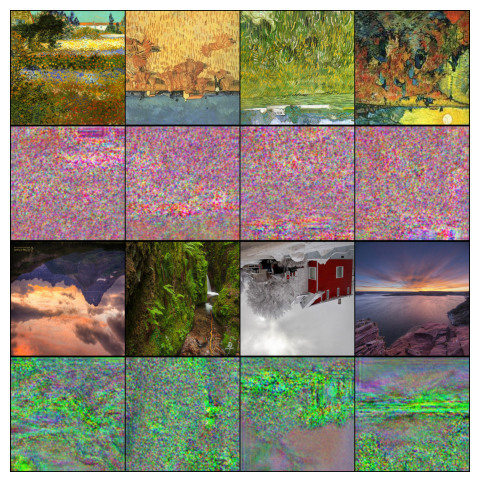

In [ ]:
sample_images(train_loader, G_AB, G_BA)

# Training
It learns a map G_AB : A -> B and its inverse map G_BA : B -> A by using discriminators D_A and D_B.

The cycle GAN has following losses :

A)) Generator losses ::

1) Identity loss = 0.5 * (d(A, G_AB(A)) + d(B, G_BA(B)))

It makes the generator to preserve content information like horses and zebras for transformed domain.

2) GAN loss = 0.5 * (d(disc(G_A(A)), 1) + d(disc(G_B(B), 1)))

It trains the generator to fool the discriminator.

3) Cycle loss = 0.5 * (d(A, G_BA(G_AB(A))) + d(B, G_AB(G_BA(B))))

It ensures that if you take an image from domain A, pass it through G_AB to get a translated image in domain B, and then pass that through G_BA, you should get an image that is similar to the original image from domain A.

*Generator loss = a * Identity loss + b * GAN loss + c * Cycle loss*


B)) Discriminator losses ::

There is each discriminator for each domain. Each discriminator tries to discriminate between real and fake images in each domain. Fake images are transfered images from other domain.

In [ ]:
criterion_GAN = nn.MSELoss().to(device)
criterion_cycle = nn.L1Loss().to(device)
criterion_identity = nn.L1Loss().to(device)

In [ ]:
lr = 0.0002
b1 = 0.5
b2 = 0.999

In [ ]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1, b2)
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1, b2)
)

In [ ]:
n_epoches = 100
decay_epoch = 20

In [ ]:
lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

In [ ]:
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

In [ ]:
avg_losses_G = []
avg_losses_D = []
losses_path = '/content/drive/MyDrive/styleTransfer/Losses'

[Epoch 1/100, Average loss Generator = 5.119500873088836, Average loss Discriminator = 0.2794507257640362]
[Epoch 2/100, Average loss Generator = 4.8361301565170285, Average loss Discriminator = 0.17818168476223945]
[Epoch 3/100, Average loss Generator = 4.691014888286591, Average loss Discriminator = 0.1662561609596014]
[Epoch 4/100, Average loss Generator = 4.596716113090515, Average loss Discriminator = 0.15071120172739028]
[Epoch 5/100, Average loss Generator = 4.462369885444641, Average loss Discriminator = 0.1667444918304682]
[Epoch 6/100, Average loss Generator = 4.461999683380127, Average loss Discriminator = 0.1583301244676113]
[Epoch 7/100, Average loss Generator = 4.212830605506897, Average loss Discriminator = 0.16728130854666234]
[Epoch 8/100, Average loss Generator = 4.083388845920563, Average loss Discriminator = 0.16839700929820536]
[Epoch 9/100, Average loss Generator = 4.045571105480194, Average loss Discriminator = 0.16589906074106694]
[Epoch 10/100, Average loss Gen

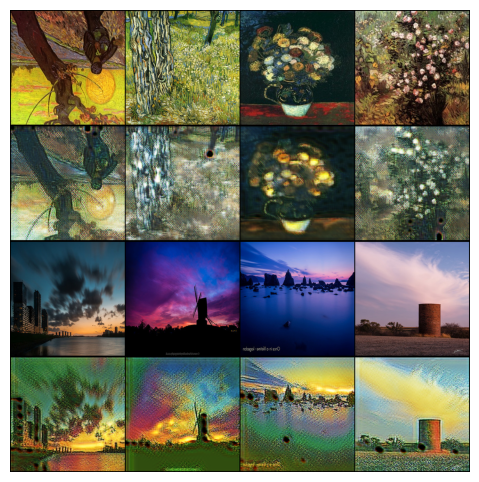

[Epoch 11/100, Average loss Generator = 3.922027382850647, Average loss Discriminator = 0.1642058449983597]
[Epoch 12/100, Average loss Generator = 3.814020428657532, Average loss Discriminator = 0.16612975671887398]
[Epoch 13/100, Average loss Generator = 3.7796020460128785, Average loss Discriminator = 0.1641423809528351]
[Epoch 14/100, Average loss Generator = 3.754576020240784, Average loss Discriminator = 0.16559084560722112]
[Epoch 15/100, Average loss Generator = 3.7777115273475648, Average loss Discriminator = 0.16022924818098544]
[Epoch 16/100, Average loss Generator = 3.656524171829224, Average loss Discriminator = 0.16791274853050708]
[Epoch 17/100, Average loss Generator = 3.6925111532211305, Average loss Discriminator = 0.16531246542930603]
[Epoch 18/100, Average loss Generator = 3.5889428448677063, Average loss Discriminator = 0.16327630661427975]
[Epoch 19/100, Average loss Generator = 3.607090480327606, Average loss Discriminator = 0.15410433109849692]
[Epoch 20/100, Av

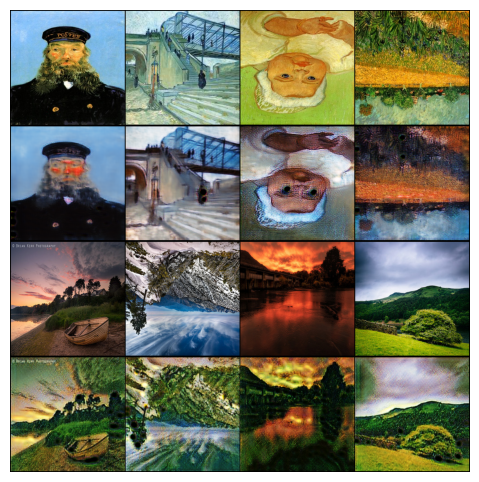

[Epoch 21/100, Average loss Generator = 3.505948884487152, Average loss Discriminator = 0.15752750404179097]
[Epoch 22/100, Average loss Generator = 3.466227195262909, Average loss Discriminator = 0.15333408556878567]
[Epoch 23/100, Average loss Generator = 3.4333723092079165, Average loss Discriminator = 0.16117002464830876]
[Epoch 24/100, Average loss Generator = 3.444351944923401, Average loss Discriminator = 0.1566967126354575]
[Epoch 25/100, Average loss Generator = 3.4498204493522646, Average loss Discriminator = 0.15849874228239058]
[Epoch 26/100, Average loss Generator = 3.411277573108673, Average loss Discriminator = 0.16043862394988537]
[Epoch 27/100, Average loss Generator = 3.3799286007881166, Average loss Discriminator = 0.15115746691823007]
[Epoch 28/100, Average loss Generator = 3.315515682697296, Average loss Discriminator = 0.15826022751629354]
[Epoch 29/100, Average loss Generator = 3.3312731838226317, Average loss Discriminator = 0.15599554158747198]
[Epoch 30/100, A

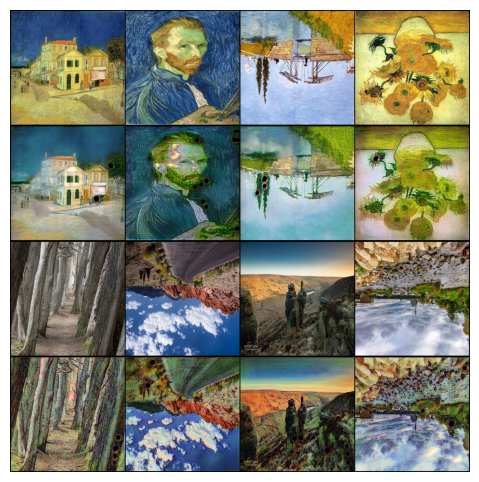

[Epoch 31/100, Average loss Generator = 3.3250544452667237, Average loss Discriminator = 0.15147761758416892]
[Epoch 32/100, Average loss Generator = 3.217577476501465, Average loss Discriminator = 0.14859733428806066]
[Epoch 33/100, Average loss Generator = 3.257920570373535, Average loss Discriminator = 0.15533117517828943]
[Epoch 34/100, Average loss Generator = 3.2293491172790527, Average loss Discriminator = 0.15481895871460438]
[Epoch 35/100, Average loss Generator = 3.195438416004181, Average loss Discriminator = 0.14833143025636672]
[Epoch 36/100, Average loss Generator = 3.258151273727417, Average loss Discriminator = 0.14861634597182274]
[Epoch 37/100, Average loss Generator = 3.1750557255744933, Average loss Discriminator = 0.1485847731679678]
[Epoch 38/100, Average loss Generator = 3.2063267850875854, Average loss Discriminator = 0.144363769069314]
[Epoch 39/100, Average loss Generator = 3.1887420845031738, Average loss Discriminator = 0.14595004551112653]
[Epoch 40/100, Av

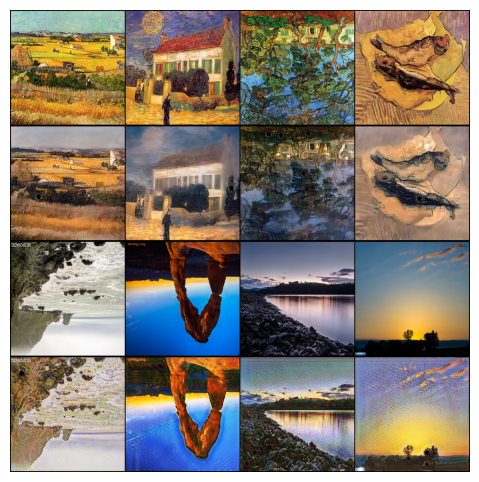

[Epoch 41/100, Average loss Generator = 3.1218843698501586, Average loss Discriminator = 0.14418185278773307]
[Epoch 42/100, Average loss Generator = 3.120895714759827, Average loss Discriminator = 0.1406159069389105]
[Epoch 43/100, Average loss Generator = 3.108447253704071, Average loss Discriminator = 0.1423174548521638]
[Epoch 44/100, Average loss Generator = 3.0701000595092776, Average loss Discriminator = 0.1449758806079626]
[Epoch 45/100, Average loss Generator = 3.0430839824676514, Average loss Discriminator = 0.14865412153303623]
[Epoch 46/100, Average loss Generator = 3.0230795454978945, Average loss Discriminator = 0.1459602312743664]
[Epoch 47/100, Average loss Generator = 3.013674092292786, Average loss Discriminator = 0.14558483131229877]
[Epoch 48/100, Average loss Generator = 2.9951326298713683, Average loss Discriminator = 0.13882367976009846]
[Epoch 49/100, Average loss Generator = 2.9911772108078, Average loss Discriminator = 0.14787805564701556]
[Epoch 50/100, Avera

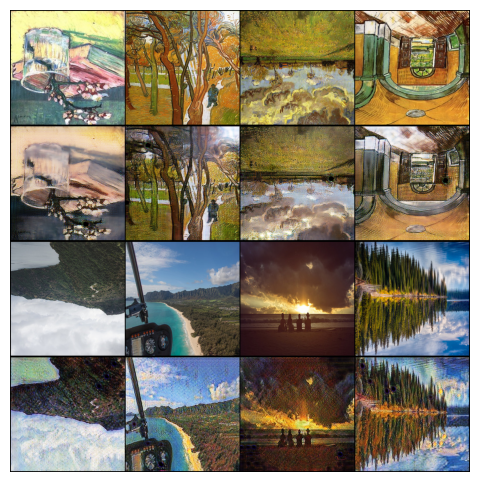

[Epoch 51/100, Average loss Generator = 2.9412084221839905, Average loss Discriminator = 0.13703446712344886]
[Epoch 52/100, Average loss Generator = 2.9479631853103636, Average loss Discriminator = 0.13713849309831858]
[Epoch 53/100, Average loss Generator = 2.968560104370117, Average loss Discriminator = 0.1367394269257784]
[Epoch 54/100, Average loss Generator = 2.928980770111084, Average loss Discriminator = 0.13733510710299016]
[Epoch 55/100, Average loss Generator = 2.973444619178772, Average loss Discriminator = 0.13312349531799555]
[Epoch 56/100, Average loss Generator = 2.927118225097656, Average loss Discriminator = 0.1343599307537079]
[Epoch 57/100, Average loss Generator = 2.887483389377594, Average loss Discriminator = 0.13190449435263873]
[Epoch 58/100, Average loss Generator = 2.9165490746498106, Average loss Discriminator = 0.1305168968439102]
[Epoch 59/100, Average loss Generator = 2.9141293573379516, Average loss Discriminator = 0.13021398402750492]
[Epoch 60/100, Ave

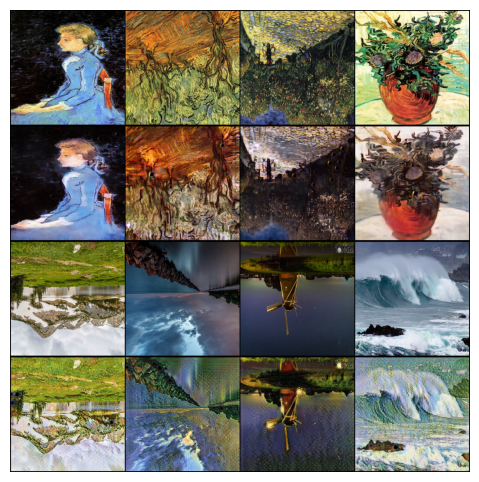

[Epoch 61/100, Average loss Generator = 2.8603922057151796, Average loss Discriminator = 0.1294710575416684]
[Epoch 62/100, Average loss Generator = 2.870845890045166, Average loss Discriminator = 0.12705615106970072]
[Epoch 63/100, Average loss Generator = 2.849376547336578, Average loss Discriminator = 0.12668785605579613]
[Epoch 64/100, Average loss Generator = 2.8448685073852538, Average loss Discriminator = 0.1277533907815814]
[Epoch 65/100, Average loss Generator = 2.8265609979629516, Average loss Discriminator = 0.12263175643980503]
[Epoch 66/100, Average loss Generator = 2.8115611624717713, Average loss Discriminator = 0.12448572650551797]
[Epoch 67/100, Average loss Generator = 2.7946101999282837, Average loss Discriminator = 0.12451899483799934]
[Epoch 68/100, Average loss Generator = 2.777406380176544, Average loss Discriminator = 0.12822732210159302]
[Epoch 69/100, Average loss Generator = 2.811262519359589, Average loss Discriminator = 0.12109051942825318]
[Epoch 70/100, A

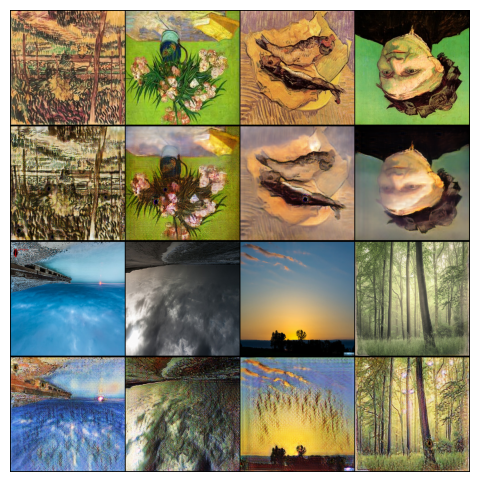

[Epoch 71/100, Average loss Generator = 2.779356129169464, Average loss Discriminator = 0.1152652359008789]
[Epoch 72/100, Average loss Generator = 2.7724784231185913, Average loss Discriminator = 0.1172068165615201]
[Epoch 73/100, Average loss Generator = 2.7799213123321533, Average loss Discriminator = 0.12118616797029973]


In [ ]:
for epoch in range(n_epoches):
    losses_G = []
    losses_D = []
    for i, (real_A, real_B) in enumerate(train_loader):
        real_A, real_B = real_A.type(torch.cuda.FloatTensor), real_B.type(torch.cuda.FloatTensor)

        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(torch.cuda.FloatTensor)
        fake = torch.zeros(out_shape).type(torch.cuda.FloatTensor)

        """Train Generators"""
        # set to training mode in the begining, beacause sample_images will set it to eval mode
        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        # identity loss
        loss_id_A = criterion_identity(fake_B, real_A)
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss, train G to make D think it's true
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # cycle loss
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Train Generator
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle

        loss_G.backward()
        optimizer_G.step()

        """Train Discriminator A"""
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        """Train Discriminator B"""
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        losses_G.append(loss_G.item())
        losses_D.append(loss_D.item())


    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()


    avg_loss_G = sum(losses_G) / len(losses_G)
    avg_loss_D = sum(losses_D) / len(losses_D)
    avg_losses_G.append(avg_loss_G)
    avg_losses_D.append(avg_loss_D)
    print(f'[Epoch {epoch+1}/{n_epoches}, Average loss Generator = {avg_loss_G}, Average loss Discriminator = {avg_loss_D}]')


    # save
    if (epoch+1) % 10 == 0:
        sample_images(train_loader, G_AB, G_BA)
        base_path = '/content/drive/MyDrive/styleTransfer/Model_checkpoint'

        G_AB_path = os.path.join(base_path, 'generator_a2b.pth')
        torch.save(G_AB.state_dict(), G_AB_path)
        G_BA_path = os.path.join(base_path, 'generator_b2a.pth')
        torch.save(G_BA.state_dict(), G_BA_path)
        D_A_path = os.path.join(base_path, 'discriminator_a.pth')
        torch.save(D_A.state_dict(), D_A_path)
        D_B_path = os.path.join(base_path, 'discriminator_b.pth')
        torch.save(D_B.state_dict(), D_B_path)

np.savetxt(os.path.join(losses_path, 'average_losses_G.txt'), avg_losses_G)
np.savetxt(os.path.join(losses_path, 'average_losses_D.txt'), avg_losses_D)

# Test

## Test dataset

In [11]:
base_path = '/content/drive/MyDrive/styleTransfer/Model_checkpoint'

G_AB_path = os.path.join(base_path, 'generator_a2b.pth')
G_AB.load_state_dict(torch.load(G_AB_path, map_location=device))
G_BA_path = os.path.join(base_path, 'generator_b2a.pth')
G_BA.load_state_dict(torch.load(G_BA_path, map_location=device))


<All keys matched successfully>

In [13]:
test_data_dir = '/content/drive/MyDrive/styleTransfer/vangogh2photo_dataset'
test_A_len = len(os.listdir(os.path.join(test_data_dir, 'testA')))
test_B_len = len(os.listdir(os.path.join(test_data_dir, 'testB')))
print(f'{test_A_len} Van Gogh Paintings, {test_B_len} camera photos')


874 Van Gogh Paintings, 1038 camera photos


In [14]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, tfms, mode = 'Train'):
        super(ImageDataset, self).__init__()
        dir_trainA = os.path.join(data_dir, 'trainA')
        dir_trainB = os.path.join(data_dir, 'trainB')
        dir_testA = os.path.join(data_dir, 'testA')
        dir_testB = os.path.join(data_dir, 'testB')
        if mode == 'Train':
            self.files_a = [os.path.join(dir_trainA, name) for name in sorted(os.listdir(dir_trainA))]
            self.files_b = [os.path.join(dir_trainB, name) for name in sorted(os.listdir(dir_trainB))]
        elif mode == 'Test':
            self.files_a = [os.path.join(dir_testA, name) for name in sorted(os.listdir(dir_testA))]
            self.files_b = [os.path.join(dir_testB, name) for name in sorted(os.listdir(dir_testB))]
        else:
            raise NotImplementedError
        self.tfms = tfms
    def __len__(self):
        return len(self.files_a)
    def __getitem__(self, index):
        random_index = np.random.randint(0, len(self.files_b))
        #print(len(self.files_a), len(self.files_b[:400]))
        file_a = Image.open(self.files_a[index])
        file_b = Image.open(self.files_b[index])
        file_a = file_a.resize((256, 256))
        file_b = file_b.resize((256, 256))


        if self.tfms is not None:
            file_a = self.tfms(file_a)
            file_b = self.tfms(file_b)
        return file_a, file_b



In [15]:
stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tfms = tt.Compose([#tt.Resize(256),
                tt.RandomHorizontalFlip(0.5),
                tt.RandomVerticalFlip(0.5),
                tt.ToTensor(),
                tt.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
                tt.Normalize(*stats)])

test_ds = ImageDataset(data_dir, tfms, 'Test')

batch_size = 8
test_loader = DataLoader(test_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Visualise transformation of test samples from each domain

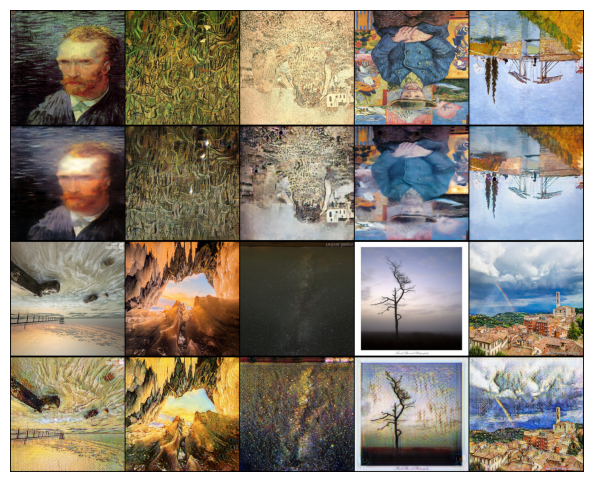

In [16]:
sample_images(test_loader, G_AB, G_BA)

## Compute metrics

We have used FID Score (Frenchet Inception Distance) and LPIPS Score (Learned Perceptual Image Patch Similarity) for evaluation.

FID Score :

FID Score is the measure of the similarity between the distribution of generated images and real images. (https://torchmetrics.readthedocs.io/en/stable/image/frechet_inception_distance.html)

Lower FID scores generally indicate better image quality and realism.

LPIPS Score :

Evaluate the distance between image patches. Lower means more similar.(https://pypi.org/project/lpips/)

In [17]:
from skimage.transform import resize

In [18]:
! pip install torchmetrics[image]
! pip install torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.0 MB/s eta 0:00:00


In [19]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.fid import FrechetInceptionDistance

In [20]:
def scale_imgs(images, shape):
    imgs = []
    for img in images:
        scaled_img = resize(img, shape, 0)
        imgs.append(scaled_img)
    return np.asarray(imgs)

In [21]:
def compute_fid_A(G_BA, dataloader, shape=(256, 256, 3)):
    print("Computing FID score...")
    fid = FrechetInceptionDistance(feature=64)

    G_BA.eval()
    with torch.no_grad():
        for img_A, img_B in dataloader:
            # Transform images
            img_A_tensor = img_A.to(device).type(torch.cuda.FloatTensor)
            img_B_tensor = img_B.to(device).type(torch.cuda.FloatTensor)

            # Perform style transfer
            styled_img_B = G_BA(img_B_tensor)


            gen_imgs = styled_img_B.cpu().detach().numpy().astype('float32')
            true_imgs = img_A_tensor.cpu().numpy().astype('float32')

            gen_tensor = torch.from_numpy(scale_imgs(gen_imgs, shape))
            true_tensor = torch.from_numpy(scale_imgs(true_imgs, shape))

            # Reshape into Nx3xHxW
            H, W = shape[:2]
            gen_tensor = gen_tensor.view(-1, 3, H, W).to(torch.uint8)
            true_tensor = true_tensor.view(-1, 3, H, W).to(torch.uint8)

            # FID
            fid.update(gen_tensor, real=False)
            fid.update(true_tensor, real=True)

    score = fid.compute()
    print(f'FID score A = {score}')


In [22]:
compute_fid_A(G_BA, test_loader)

Computing FID score...


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 149MB/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


FID score A = 1.2771543822509557e-08


In [23]:
def compute_fid_B(G_AB, dataloader, shape=(256, 256, 3)):
    print("Computing FID score...")
    fid = FrechetInceptionDistance(feature=64)

    G_AB.eval()

    with torch.no_grad():
        for img_A, img_B in dataloader:
            # Transform images
            img_A_tensor = img_A.to(device).type(torch.cuda.FloatTensor)
            img_B_tensor = img_B.to(device).type(torch.cuda.FloatTensor)

            # Perform style transfer
            styled_img_A = G_AB(img_A_tensor)



            gen_imgs = styled_img_A.cpu().detach().numpy().astype('float32')
            true_imgs = img_B_tensor.cpu().numpy().astype('float32')

            gen_tensor = torch.from_numpy(scale_imgs(gen_imgs, shape))
            true_tensor = torch.from_numpy(scale_imgs(true_imgs, shape))

            # Reshape into Nx3xHxW
            H, W = shape[:2]
            gen_tensor = gen_tensor.view(-1, 3, H, W).to(torch.uint8)
            true_tensor = true_tensor.view(-1, 3, H, W).to(torch.uint8)

            # FID
            fid.update(gen_tensor, real=False)
            fid.update(true_tensor, real=True)

    score = fid.compute()
    print(f'FID score B = {score}')


In [24]:
compute_fid_B(G_AB, test_loader)

Computing FID score...
FID score B = 1.7840944528579712


In [39]:
def normalize_images(imgs):
    # Assuming imgs is a PyTorch tensor
    return 2 * (imgs / 255.0) - 0.5

In [40]:
def compute_lpips_A(G_BA, dataloader, shape=(256, 256, 3)):
    print("Computing LPIPS score...")
    lpips = LearnedPerceptualImagePatchSimilarity()

    G_BA.eval()
    with torch.no_grad():
        for img_A, img_B in dataloader:
            # Transform images
            img_A_tensor = img_A.to(device).type(torch.cuda.FloatTensor)
            img_B_tensor = img_B.to(device).type(torch.cuda.FloatTensor)

            # Perform style transfer
            styled_img_B = G_BA(img_B_tensor)


            gen_imgs = normalize_images(styled_img_B.cpu().detach().numpy().astype('float32'))
            true_imgs = normalize_images(img_A_tensor.cpu().numpy().astype('float32'))


            gen_tensor = torch.from_numpy(scale_imgs(gen_imgs, shape))
            true_tensor = torch.from_numpy(scale_imgs(true_imgs, shape))

            # Reshape into Nx3xHxW
            H, W = shape[:2]
            gen_tensor = gen_tensor.view(-1, 3, H, W)#.to(torch.uint8)
            true_tensor = true_tensor.view(-1, 3, H, W)#.to(torch.uint8)

            # LPIPS
            lpips.update(gen_tensor, true_tensor)


    score = lpips.compute()
    print(f'LPIPS score A = {score}')


In [41]:
compute_lpips_A(G_BA, test_loader)

Computing LPIPS score...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


LPIPS score A = 0.0006569788092747331


In [46]:
def compute_lpips_B(G_AB, dataloader, shape=(256, 256, 3)):
    print("Computing LPIPS score...")
    lpips = LearnedPerceptualImagePatchSimilarity()

    G_AB.eval()

    with torch.no_grad():
        for img_A, img_B in dataloader:
            # Transform images
            img_A_tensor = img_A.to(device).type(torch.cuda.FloatTensor)
            img_B_tensor = img_B.to(device).type(torch.cuda.FloatTensor)

            # Perform style transfer
            styled_img_A = G_AB(img_A_tensor)



            gen_imgs = normalize_images(styled_img_A.cpu().detach().numpy().astype('float32'))
            true_imgs = normalize_images(img_B_tensor.cpu().numpy().astype('float32'))

            gen_tensor = torch.from_numpy(scale_imgs(gen_imgs, shape))
            true_tensor = torch.from_numpy(scale_imgs(true_imgs, shape))

            # Reshape into Nx3xHxW
            H, W = shape[:2]
            gen_tensor = gen_tensor.view(-1, 3, H, W)
            true_tensor = true_tensor.view(-1, 3, H, W)

            # LPIPS
            lpips.update(gen_tensor, true_tensor)

    score = lpips.compute()
    print(f'LPIPS score B = {score}')


In [47]:
compute_lpips_B(G_AB, test_loader)

Computing LPIPS score...
LPIPS score B = 0.0007442692876793444


# Conclusion :

FID score A = 1.2771543822509557e-08

FID score B = 1.7840944528579712

LPIPS score A = 0.0006569788092747331

LPIPS score B = 0.0007442692876793444


We see, this implementation gives better translation in domain A than B.

Note: Domain A = VanGogh domain, domain B = camera photos.

Further training might solve this.

Notes and Further Work :

-> Getting it to work in the market we need to collect datasets of particular style and will need particular set of models for each pair of domains. Hence will require lots of memory as well.

-> Implement further methods like AdaIN, Neural Style Transfer.

-> Think of better way to do this!